# Lecture 2 Data Science in Active Trading Strategy
## Part 1: Bootstrap & Monte Carlo Methods

## 1 Bootstrap
**Just like "Shadow Clone Jutsu (影分身の術 Kage Bunshin no Jutsu)"**

<img src="Jutsu_ShadowClones_Naruto.jpg" width="600">

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader import DataReader
from datetime import datetime
import scipy.stats as ss
import yfinance as yf

[*********************100%***********************]  1 of 1 completed

sample mean: $31.725554053178232
sample standard deviation: $29.642195497534264
sample skewness:  1.8799515481002462
sample kurtosis:  5.771775081455373


<Axes: ylabel='Density'>

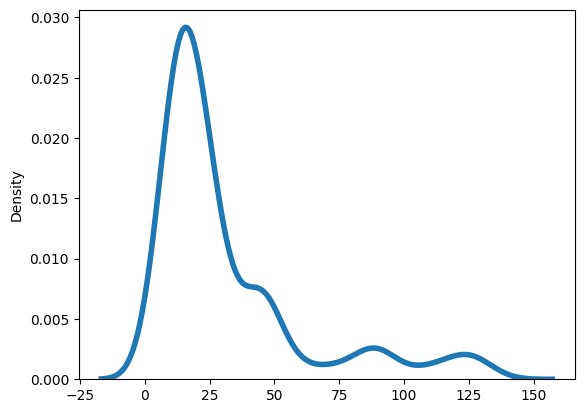

In [2]:
start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)

stock_symbol = "NVDA"
stocks = yf.download(stock_symbol,start_date ,end_date)
stocks['Adj Close'].describe() # summary statistics
X = stocks['Adj Close'].values
print(f"sample mean: ${np.mean(X)}")
print(f"sample standard deviation: ${np.std(X)}")
print("sample skewness: ",ss.skew(X, axis=0, bias=True))
print("sample kurtosis: ",ss.kurtosis(X, axis=0, bias=True)+3)
# Empirical Distribution
sns.kdeplot(data=X,linewidth=4)

In [3]:
"Bootstrap"
T= X.shape[0]
B = 1000 # 5000, 100000 [250 9750]
mu_boot = np.zeros(B)
se_boot = np.zeros(B)
x_boot_std = np.zeros(B)
for i in range(0, B):
     x_boot = X[np.random.choice(T,T)]
     mu_boot[i] = np.mean(x_boot)
     se_boot[i] = np.std(x_boot)/np.sqrt(T) # std of mu_boot
     x_boot_std[i] = np.std(x_boot) # std of x_boot
     # CLT: std(x_boost) = sqrt(T)*std(mu_boot)
mu_boot = np.sort(mu_boot)
se_boot = np.sort(se_boot)
xboot_std = np.sort(x_boot_std)
print("Statistics about the Mean")
print("95% confidence interval of mu_boot:", mu_boot[25], mu_boot[975])
print("95% confidence interval of std_boot of mu :", se_boot[25], se_boot[975])
print("\n")
print("Statistics about the Sample")
print(f"95% confidence interval of {stock_symbol} stock price std (method 1):", se_boot[25]*np.sqrt(T), se_boot[975]*np.sqrt(T))
print(f"95% confidence interval of {stock_symbol} stock price std (method 2):", xboot_std[25], xboot_std[975])

Statistics about the Mean
95% confidence interval of mu_boot: 30.026360964247072 33.425183255181
95% confidence interval of std_boot of mu : 0.8125499962956666 0.917459342402303


Statistics about the Sample
95% confidence interval of NVDA stock price std (method 1): 27.840955818139992 31.435536438631466
95% confidence interval of NVDA stock price std (method 2): 27.840955818139992 31.435536438631466


## 2 Monte Carlo Methods
**Just like "Tsukuyomi (月読)"**

<img src="Jutsu_Tsukuyomi_Itachi.jpg" width="400">

[*********************100%***********************]  1 of 1 completed

sample mean: $95.51982825142997
sample standard deviation: $23.7456496011127
95% confidence interval of mu_mc: $91.9253699124138 to $99.23570953710558


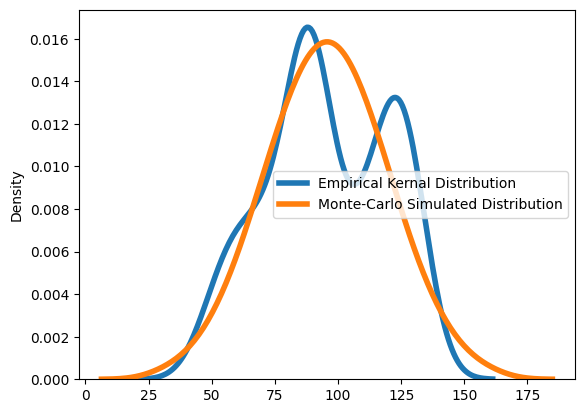

In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader import DataReader
from datetime import datetime
import yfinance as yf

start_date = datetime(2024,1,1)
end_date = datetime(2024,8,31)

stock_symbol = "NVDA"
stocks = yf.download(stock_symbol,start_date ,end_date)
stocks['Adj Close'].describe() # summary statistics
X = stocks['Adj Close'].values
mu = np.mean(X)
se = np.std(X)
print(f"sample mean: ${mu}")
print(f"sample standard deviation: ${se}")

T = X.shape[0]
M = 1000
mu_mc = np.zeros(M)
se_mc = np.zeros(M)
t_stat_mc = np.zeros(M)
y_mc = 0
for i in range(0, M):
    # siumulate the path of AAPL
    simulatedPrice = mu + se*np.random.normal(0,1,T) 
    mu_mc[i] = np.mean(simulatedPrice)
    se_mc[i] = np.std(simulatedPrice)/np.sqrt(T)
    y_mc += np.sort(simulatedPrice)
    
mu_mc = np.sort(mu_mc)
se_mc = np.sort(se_mc)/np.sqrt(T)
y_mc = y_mc/M

print(f"95% confidence interval of mu_mc: ${mu_mc[25]} to ${mu_mc[975]}")
fig, ax = plt.subplots()
sns.kdeplot(data=X, linewidth=4)
sns.kdeplot(data=y_mc, linewidth=4)
ax.legend(['Empirical Kernal Distribution', 'Monte-Carlo Simulated Distribution'])

### 3 Monte Carlo Mixture

[*********************100%***********************]  1 of 1 completed
C:\Users\56111\AppData\Local\Temp\ipykernel_634196\2190394618.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulatedPrice[t] = p1*(u<p)+p2*(u>=p);


sample mean: $95.51982825142997
sample standard deviation: $23.7456496011127
confidence interval of mu_mc: 93.00099010109197 99.1576785539298


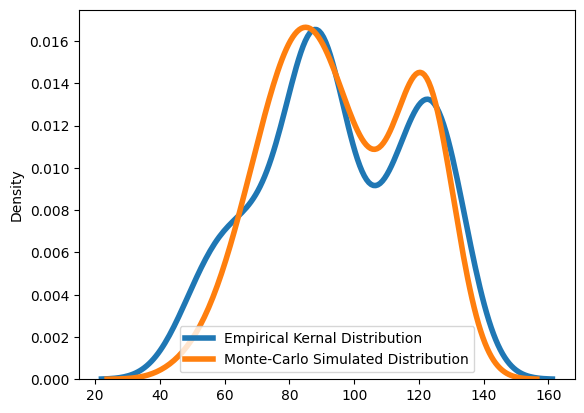

In [5]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader import DataReader
from datetime import datetime
import yfinance as yf

start_date = datetime(2024,1,1)
end_date = datetime(2024,8,31)

stock_symbol = "NVDA"
stocks = yf.download(stock_symbol,start_date ,end_date)
stocks['Adj Close'].describe() # summary statistics
X = stocks['Adj Close'].values
T = len(X) # number of trading days
mu = np.mean(X)
se = np.std(X)
print(f"sample mean: ${mu}")
print(f"sample standard deviation: ${se}")

# observe kde plot and assign values to key parameters
mu_1 = 85 # mean of the first component distribution
sigma_1 = 15 # standard deviation of the first component distribution
mu_2 = 122 # mean of the second component distribution
sigma_2 = 5 # standard deviation of the second component distribution
p = 0.7

def generateEmpiricalDist(mu_1, sigma_1, mu_2, sigma_2, p, T):
    #Normal Mixture
    simulatedPrice = np.zeros(T-1);
    for t in range(0,T-1):
        p1 = mu_1 + sigma_1*np.random.normal(0,1,1);
        p2 = mu_2 + sigma_2*np.random.normal(0,1,1);
        u = np.random.uniform(0,1,1);
        simulatedPrice[t] = p1*(u<p)+p2*(u>=p);

    return simulatedPrice


T = X.shape[0]
M = 1000
mu_mc = np.zeros(M)
y_mc = 0
for i in range(0, M):
    simulatedPrice = generateEmpiricalDist(mu_1, sigma_1, mu_2, sigma_2, p, T)
    mu_mc[i] = np.mean(simulatedPrice)
    y_mc += np.sort(simulatedPrice)

y_mc = y_mc/M
mu_mc = np.sort(mu_mc)

print("confidence interval of mu_mc:", mu_mc[25], mu_mc[975])

# Visualization
fig, ax = plt.subplots()
sns.kdeplot(data=X, linewidth=4) # the blue line
sns.kdeplot(data=y_mc, linewidth=4) # the orange line
ax.legend(['Empirical Kernal Distribution', 'Monte-Carlo Simulated Distribution'])